In [42]:
#ALGORITHM = 'XG Boost'
#ALGORITHM = 'Linear Regression (Ridge)'
#ALGORITHM = 'KNN'
#ALGORITHM = 'Decision Tree'
#ALGORITHM = 'Random Forest'
ALGORITHM = 'CatBoost'

ALGORITHM_DETAIL = 'random search'
#DATA_DETAIL = []
#DATA_DETAIL = ['no scale','no dummies']
DATA_DETAIL = ['no dummies']
VERSION = '06'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

print(f'ALGORITHM: {ALGORITHM}')
print(f'ALGORITHM_DETAIL: {ALGORITHM_DETAIL}')
print(f'DATA_DETAIL: {DATA_DETAIL}')
print(f'DATA VERSION: {VERSION}')


ALGORITHM: CatBoost
ALGORITHM_DETAIL: random search
DATA_DETAIL: ['no dummies']
DATA VERSION: 06


In [43]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored
from time import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import pickle

import json
from datetime import datetime
import matplotlib.pyplot as plt

with open('../../z_envs/_envs.json') as f:
    env_vars = json.loads(f.read())
print(env_vars)

try:
    import google.colab

    run_env = 'colab'
except:
    try:
        run_env = env_vars['notebook_environment']
    except:
        run_env = 'unknown'

use_gpu = env_vars.get('use_gpu', False)
debug_mode = env_vars.get('debug_mode', False)
quick_mode = env_vars.get('quick_mode', False)
OVERRIDE_CV = env_vars.get('quick_override_cv_splits', None) if quick_mode else None
OVERRIDE_N_ITER = env_vars.get('quick_override_n_iter', None) if quick_mode else None
OVERRIDE_JOBS = env_vars.get('quick_override_n_jobs', None) if quick_mode else None
#if quick_mode:OVERRIDE_CV, OVERRIDE_N_ITER = 2, 10

already_timed = False
no_dummies = 'no dummies' in DATA_DETAIL
no_scaling = 'no scaling' in DATA_DETAIL

if run_env not in ['colab', 'gradient', 'cloud']:
    cloud_run = False
    from functions_20221109 import set_csv_directory, get_columns
    from functions_modelling_20221109 import make_modelling_pipeline, tidy_dataset, preprocess, feature_engineer, create_train_test_data
    from functions_modelling_20221109 import get_cv_params, fit_model_with_cross_validation, get_best_estimator_average_time
    from functions_modelling_20221109 import get_results, update_results, get_chosen_model
    from functions_modelling_20221109 import get_hyperparameters

    set_csv_directory('final_split')
else:
    cloud_run = True
    import sys
    import os

    module_path = os.path.abspath(os.path.join('..', '..', '..'))
    if module_path not in sys.path:
        #sys.path.append(module_path+"\\zfunctions")
        sys.path.append(module_path)

    from functions_20221109 import set_csv_directory, get_columns
    #from functions_20221109 import add_supplements, get_combined_dataset
    from functions_modelling_20221109 import make_modelling_pipeline, tidy_dataset, preprocess, feature_engineer, create_train_test_data
    from functions_modelling_20221109 import get_cv_params, fit_model_with_cross_validation, get_best_estimator_average_time
    from functions_modelling_20221109 import get_results, update_results, get_chosen_model
    from functions_modelling_20221109 import get_hyperparameters


{'notebook_environment': 'gradient', 'use_gpu': True, 'debug_mode': False, 'quick_mode': False, 'quick_override_cv_splits': 2, 'quick_override_n_iter': 10, 'quick_override_n_jobs': 3}


In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

starter_pipe = Pipeline([
    #('mms', MinMaxScaler()),
    ('std_scaler', StandardScaler()),
    ('model', get_chosen_model(ALGORITHM))
])
starter_pipe

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7fbc9e839460>)])

In [45]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [46]:
def get_source_dataframe(rows=cutdown_rows, folder_prefix='../../../'):
    retrieval_type = None

    filename = f'df_listings_v{VERSION}.csv'
    remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
    df_pathname_raw = folder_prefix + f'data/source/{filename}'
    df_pathname_tidy = folder_prefix + f'data/final/{filename}'

    if cloud_run:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', folder_prefix + remote_pathname)
    else:
        inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', df_pathname_tidy)

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type

In [47]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../../')
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

print(df.shape)

loaded data from ../../../https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/df_listings_v06.csv
(46871, 9)


In [48]:
df.head(30)

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD
35429088,599950.0,2.0,1.0,0.238187,51.577030,-0.141230,0.077310,0.036810,NaN
44749111,475000.0,2.0,1.0,0.410550,51.370050,-0.212410,0.129670,0.107990,FREEHOLD
46204665,435000.0,3.0,2.0,0.314779,51.539070,-0.198935,0.039350,0.094515,LEASEHOLD
49020666,200000.0,1.0,1.0,0.875911,51.539959,-0.380863,0.040239,0.276443,LEASEHOLD
49036279,275000.0,2.0,1.0,0.474368,51.541780,0.037890,0.042060,0.142310,LEASEHOLD
49303873,450000.0,3.0,2.0,0.577040,51.524880,0.187200,0.025160,0.291620,FREEHOLD


In [49]:
df.isnull().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [50]:
df.info()
df.describe()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46871 entries, 14520525 to 126181118
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                46871 non-null  float64
 1   bedrooms             46871 non-null  float64
 2   bathrooms            46871 non-null  float64
 3   nearestStation       46871 non-null  float64
 4   location.latitude    46871 non-null  float64
 5   location.longitude   46871 non-null  float64
 6   latitude_deviation   46871 non-null  float64
 7   longitude_deviation  46871 non-null  float64
 8   tenure.tenureType    44127 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [51]:
old_length = len(df)

df = preprocess(df, version=VERSION)

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 46871 ==> 46871


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [52]:
df.isna().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [53]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

46871 ==> 44127


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation
count,44127.000000,44127.000000,44127.00000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000
mean,425224.642373,1.990981,1.18134,0.438522,51.496711,-0.113106,0.064544,0.123699
std,107203.332660,0.827621,0.40893,0.324152,0.077267,0.155863,0.042583,0.095220
min,100000.000000,1.000000,1.00000,0.000000,51.298317,-0.498315,0.000000,0.000000
25%,349950.000000,1.000000,1.00000,0.227551,51.438303,-0.210633,0.029023,0.043551
50%,425000.000000,2.000000,1.00000,0.368351,51.498780,-0.101910,0.058904,0.098750
75%,515000.000000,3.000000,1.00000,0.559486,51.556343,-0.010854,0.094620,0.191727
max,600000.000000,7.000000,5.00000,7.197700,51.683185,0.279726,0.201403,0.393895


In [54]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index, df_features, df_labels = create_train_test_data(
    df,
    categories=categories,
    RANDOM_STATE=RANDOM_STATE, return_index=True,
    drop_nulls=True,
    no_dummies=no_dummies
)

print(X_train[0])

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)


[3.00000000e+00 3.00000000e+00 3.16613257e-01 5.14597600e+01
 1.29390000e-01 3.99600000e-02 2.33810000e-01            nan]
(39714, 8) (4413, 8) (39714, 1) (4413, 1) (39714, 1) (4413, 1) (39714, 1) (4413, 1)


In [55]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [56]:
fitted_graph_model = starter_pipe[-1]
default_model_params = fitted_graph_model.get_params()
default_model_params

{'loss_function': 'RMSE', 'objective': 'RMSE'}

In [57]:
import sklearn

sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [58]:
if 'forest' in ALGORITHM.lower():
    y_train_orig = y_train
    y_train = y_train.ravel()
    print(y_train_orig, y_train)

In [59]:
options_block = get_hyperparameters(ALGORITHM, use_gpu, prefix='../../../')

if 'forest' in ALGORITHM.lower():
    OVERRIDE_N_ITER = 5
    if use_gpu:
        OVERRIDE_JOBS = 8

param_options, cv, n_jobs, refit, n_iter, verbose = get_cv_params(options_block, debug_mode=debug_mode,
                                                                  override_cv=OVERRIDE_CV,
                                                                  override_niter=OVERRIDE_N_ITER,
                                                                  override_njobs=OVERRIDE_JOBS)

if 'forest' in ALGORITHM.lower():
    verbose=2

print("cv:", cv, "n_jobs:", n_jobs, "refit:", refit, "n_iter:", n_iter, "verbose:", verbose)
param_options

cv: 3 n_jobs: 3 refit: True n_iter: 100 verbose: 1


{'model__learning_rate': [None, 0.01, 0.1, 1],
 'model__depth': [5, 6],
 'model__eval_metric': ['R2']}

In [60]:
if len(param_options.keys()) > 2 and not already_timed:
    already_timed = True
    %timeit starter_pipe.fit(X_train, y_train)

Learning rate set to 0.073251


/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


0:	learn: 104261.3090856	total: 7.59ms	remaining: 7.58s
1:	learn: 101419.4558723	total: 12.9ms	remaining: 6.46s
2:	learn: 98969.9611155	total: 17.4ms	remaining: 5.79s
3:	learn: 96642.9178315	total: 22.3ms	remaining: 5.56s
4:	learn: 94687.6294259	total: 26.7ms	remaining: 5.31s
5:	learn: 92819.7097631	total: 31.2ms	remaining: 5.17s
6:	learn: 91251.9095405	total: 35.3ms	remaining: 5s
7:	learn: 89844.9915078	total: 39.5ms	remaining: 4.9s
8:	learn: 88462.2606789	total: 43.3ms	remaining: 4.76s
9:	learn: 87230.6246060	total: 47.4ms	remaining: 4.7s
10:	learn: 86139.8499625	total: 51.4ms	remaining: 4.62s
11:	learn: 85164.6214758	total: 55.4ms	remaining: 4.56s
12:	learn: 84305.5986497	total: 58.5ms	remaining: 4.44s
13:	learn: 83538.4159128	total: 60.7ms	remaining: 4.27s
14:	learn: 82842.9238935	total: 62.8ms	remaining: 4.12s
15:	learn: 82222.9993394	total: 64.9ms	remaining: 3.99s
16:	learn: 81551.3718591	total: 67.1ms	remaining: 3.88s
17:	learn: 80994.3488304	total: 69.3ms	remaining: 3.78s
18:	l

/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Learning rate set to 0.073251
0:	learn: 104261.3090856	total: 2.83ms	remaining: 2.83s
1:	learn: 101419.4558723	total: 5.48ms	remaining: 2.73s
2:	learn: 98969.9611155	total: 7.57ms	remaining: 2.52s
3:	learn: 96642.9178315	total: 9.88ms	remaining: 2.46s
4:	learn: 94687.6294259	total: 12ms	remaining: 2.39s
5:	learn: 92819.7097631	total: 14.2ms	remaining: 2.35s
6:	learn: 91251.9095405	total: 16.2ms	remaining: 2.3s
7:	learn: 89844.9915078	total: 18.2ms	remaining: 2.26s
8:	learn: 88462.2606789	total: 20.3ms	remaining: 2.24s
9:	learn: 87230.6246060	total: 22.3ms	remaining: 2.21s
10:	learn: 86139.8499625	total: 24.3ms	remaining: 2.19s
11:	learn: 85164.6214758	total: 26.5ms	remaining: 2.18s
12:	learn: 84305.5986497	total: 28.6ms	remaining: 2.17s
13:	learn: 83538.4159128	total: 30.8ms	remaining: 2.17s
14:	learn: 82842.9238935	total: 33ms	remaining: 2.16s
15:	learn: 82222.9993394	total: 35.1ms	remaining: 2.16s
16:	learn: 81551.3718591	total: 37.5ms	remaining: 2.17s
17:	learn: 80994.3488304	total:

/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Learning rate set to 0.073251
0:	learn: 104261.3090856	total: 2.77ms	remaining: 2.77s
1:	learn: 101419.4558723	total: 6.75ms	remaining: 3.37s
2:	learn: 98969.9611155	total: 10.8ms	remaining: 3.58s
3:	learn: 96642.9178315	total: 14.9ms	remaining: 3.71s
4:	learn: 94687.6294259	total: 18.5ms	remaining: 3.69s
5:	learn: 92819.7097631	total: 22.8ms	remaining: 3.77s
6:	learn: 91251.9095405	total: 26.6ms	remaining: 3.77s
7:	learn: 89844.9915078	total: 30.5ms	remaining: 3.79s
8:	learn: 88462.2606789	total: 33.9ms	remaining: 3.73s
9:	learn: 87230.6246060	total: 37.9ms	remaining: 3.76s
10:	learn: 86139.8499625	total: 41.3ms	remaining: 3.71s
11:	learn: 85164.6214758	total: 45.3ms	remaining: 3.73s
12:	learn: 84305.5986497	total: 49.4ms	remaining: 3.75s
13:	learn: 83538.4159128	total: 53.6ms	remaining: 3.77s
14:	learn: 82842.9238935	total: 57.4ms	remaining: 3.77s
15:	learn: 82222.9993394	total: 61.6ms	remaining: 3.79s
16:	learn: 81551.3718591	total: 65.8ms	remaining: 3.81s
17:	learn: 80994.3488304	t

/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Learning rate set to 0.073251
0:	learn: 104261.3090856	total: 2.14ms	remaining: 2.13s
1:	learn: 101419.4558723	total: 4.43ms	remaining: 2.21s
2:	learn: 98969.9611155	total: 6.22ms	remaining: 2.07s
3:	learn: 96642.9178315	total: 8.09ms	remaining: 2.01s
4:	learn: 94687.6294259	total: 9.81ms	remaining: 1.95s
5:	learn: 92819.7097631	total: 11.6ms	remaining: 1.92s
6:	learn: 91251.9095405	total: 13.4ms	remaining: 1.9s
7:	learn: 89844.9915078	total: 15ms	remaining: 1.87s
8:	learn: 88462.2606789	total: 16.9ms	remaining: 1.86s
9:	learn: 87230.6246060	total: 18.6ms	remaining: 1.84s
10:	learn: 86139.8499625	total: 20.3ms	remaining: 1.83s
11:	learn: 85164.6214758	total: 22ms	remaining: 1.81s
12:	learn: 84305.5986497	total: 23.8ms	remaining: 1.81s
13:	learn: 83538.4159128	total: 25.5ms	remaining: 1.8s
14:	learn: 82842.9238935	total: 27.2ms	remaining: 1.79s
15:	learn: 82222.9993394	total: 29ms	remaining: 1.78s
16:	learn: 81551.3718591	total: 30.8ms	remaining: 1.78s
17:	learn: 80994.3488304	total: 32

/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Learning rate set to 0.073251
0:	learn: 104261.3090856	total: 2.42ms	remaining: 2.41s
1:	learn: 101419.4558723	total: 4.72ms	remaining: 2.36s
2:	learn: 98969.9611155	total: 6.94ms	remaining: 2.31s
3:	learn: 96642.9178315	total: 9.22ms	remaining: 2.29s
4:	learn: 94687.6294259	total: 11.5ms	remaining: 2.29s
5:	learn: 92819.7097631	total: 13.7ms	remaining: 2.27s
6:	learn: 91251.9095405	total: 15.8ms	remaining: 2.25s
7:	learn: 89844.9915078	total: 18ms	remaining: 2.24s
8:	learn: 88462.2606789	total: 20.2ms	remaining: 2.23s
9:	learn: 87230.6246060	total: 22.4ms	remaining: 2.22s
10:	learn: 86139.8499625	total: 24.5ms	remaining: 2.21s
11:	learn: 85164.6214758	total: 26.7ms	remaining: 2.2s
12:	learn: 84305.5986497	total: 28.8ms	remaining: 2.19s
13:	learn: 83538.4159128	total: 31ms	remaining: 2.18s
14:	learn: 82842.9238935	total: 33.1ms	remaining: 2.17s
15:	learn: 82222.9993394	total: 35.6ms	remaining: 2.19s
16:	learn: 81551.3718591	total: 37.8ms	remaining: 2.18s
17:	learn: 80994.3488304	total:

/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Learning rate set to 0.073251
0:	learn: 104261.3090856	total: 2.22ms	remaining: 2.22s
1:	learn: 101419.4558723	total: 4.93ms	remaining: 2.46s
2:	learn: 98969.9611155	total: 7.8ms	remaining: 2.59s
3:	learn: 96642.9178315	total: 12.5ms	remaining: 3.11s
4:	learn: 94687.6294259	total: 16.7ms	remaining: 3.33s
5:	learn: 92819.7097631	total: 21.2ms	remaining: 3.52s
6:	learn: 91251.9095405	total: 25.6ms	remaining: 3.63s
7:	learn: 89844.9915078	total: 29.7ms	remaining: 3.69s
8:	learn: 88462.2606789	total: 34.1ms	remaining: 3.76s
9:	learn: 87230.6246060	total: 38.3ms	remaining: 3.79s
10:	learn: 86139.8499625	total: 41.8ms	remaining: 3.76s
11:	learn: 85164.6214758	total: 46.3ms	remaining: 3.81s
12:	learn: 84305.5986497	total: 50.3ms	remaining: 3.82s
13:	learn: 83538.4159128	total: 54.5ms	remaining: 3.84s
14:	learn: 82842.9238935	total: 58.9ms	remaining: 3.87s
15:	learn: 82222.9993394	total: 62.5ms	remaining: 3.84s
16:	learn: 81551.3718591	total: 66.8ms	remaining: 3.86s
17:	learn: 80994.3488304	to

/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Learning rate set to 0.073251
0:	learn: 104261.3090856	total: 2.58ms	remaining: 2.58s
1:	learn: 101419.4558723	total: 5.22ms	remaining: 2.6s
2:	learn: 98969.9611155	total: 7.35ms	remaining: 2.44s
3:	learn: 96642.9178315	total: 9.62ms	remaining: 2.39s
4:	learn: 94687.6294259	total: 11.6ms	remaining: 2.31s
5:	learn: 92819.7097631	total: 13.9ms	remaining: 2.3s
6:	learn: 91251.9095405	total: 16ms	remaining: 2.27s
7:	learn: 89844.9915078	total: 18ms	remaining: 2.23s
8:	learn: 88462.2606789	total: 20ms	remaining: 2.2s
9:	learn: 87230.6246060	total: 22ms	remaining: 2.18s
10:	learn: 86139.8499625	total: 24.1ms	remaining: 2.16s
11:	learn: 85164.6214758	total: 26.1ms	remaining: 2.15s
12:	learn: 84305.5986497	total: 28.1ms	remaining: 2.13s
13:	learn: 83538.4159128	total: 30.1ms	remaining: 2.12s
14:	learn: 82842.9238935	total: 32ms	remaining: 2.1s
15:	learn: 82222.9993394	total: 34ms	remaining: 2.09s
16:	learn: 81551.3718591	total: 36ms	remaining: 2.08s
17:	learn: 80994.3488304	total: 38.1ms	remai

/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Learning rate set to 0.073251
0:	learn: 104261.3090856	total: 2.58ms	remaining: 2.58s
1:	learn: 101419.4558723	total: 5.22ms	remaining: 2.6s
2:	learn: 98969.9611155	total: 7.46ms	remaining: 2.48s
3:	learn: 96642.9178315	total: 9.92ms	remaining: 2.47s
4:	learn: 94687.6294259	total: 12.1ms	remaining: 2.4s
5:	learn: 92819.7097631	total: 14.2ms	remaining: 2.36s
6:	learn: 91251.9095405	total: 16.3ms	remaining: 2.31s
7:	learn: 89844.9915078	total: 18.3ms	remaining: 2.27s
8:	learn: 88462.2606789	total: 20.4ms	remaining: 2.24s
9:	learn: 87230.6246060	total: 22.4ms	remaining: 2.22s
10:	learn: 86139.8499625	total: 24.5ms	remaining: 2.2s
11:	learn: 85164.6214758	total: 26.7ms	remaining: 2.2s
12:	learn: 84305.5986497	total: 28.7ms	remaining: 2.18s
13:	learn: 83538.4159128	total: 30.9ms	remaining: 2.17s
14:	learn: 82842.9238935	total: 32.9ms	remaining: 2.16s
15:	learn: 82222.9993394	total: 35.1ms	remaining: 2.16s
16:	learn: 81551.3718591	total: 37.3ms	remaining: 2.16s
17:	learn: 80994.3488304	total

In [61]:
def fit_model_with_cross_validation(gs, X_train, y_train, fits):
    pipe_start = time()
    cv_result = gs.fit(X_train, y_train)
    gs.fit(X_train, y_train)
    pipe_end = time()
    average_time = round((pipe_end - pipe_start) / (fits), 2)

    print(f"Total fit/CV time      : {int(pipe_end - pipe_start)} seconds   ({pipe_start} ==> {pipe_end})")
    print()
    print(
        f'average fit/score time = {round(cv_result.cv_results_["mean_fit_time"].mean(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].mean(), 2)}s')
    print(
        f'max fit/score time     = {round(cv_result.cv_results_["mean_fit_time"].max(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].max(), 2)}s')
    print(f'refit time             = {round(cv_result.refit_time_, 2)}s')

    #return cv_result, average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])
    return average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])


crossval_runner = RandomizedSearchCV(
    estimator=starter_pipe,
    param_distributions=param_options,
    cv=cv, n_jobs=n_jobs,  # get the AVX/AVX2 info if use n_jobs > 2
    verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
    refit=refit,
    return_train_score=True,  #n_iter=n_iter,
    n_iter=n_iter,  # 1, #3
    error_score='raise'
)

cv_average_fit_time, cv_best_model_fit_time, total_fits = fit_model_with_cross_validation(
    crossval_runner, X_train, y_train, fits=cv * n_iter)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid 

Learning rate set to 0.068705
0:	learn: 0.0494289	total: 52.5ms	remaining: 52.4s
1:	learn: 0.0925262	total: 55.6ms	remaining: 27.7s
2:	learn: 0.1287153	total: 59.3ms	remaining: 19.7s
3:	learn: 0.1636382	total: 61.4ms	remaining: 15.3s
4:	learn: 0.1912097	total: 63.5ms	remaining: 12.6s
5:	learn: 0.2192986	total: 65.7ms	remaining: 10.9s
6:	learn: 0.2440010	total: 69.4ms	remaining: 9.84s
7:	learn: 0.2659051	total: 71.2ms	remaining: 8.83s
8:	learn: 0.2858063	total: 73.1ms	remaining: 8.05s
9:	learn: 0.3013224	total: 75.1ms	remaining: 7.43s
10:	learn: 0.3163465	total: 77.3ms	remaining: 6.95s
11:	learn: 0.3309306	total: 79.6ms	remaining: 6.55s
12:	learn: 0.3432699	total: 82.9ms	remaining: 6.29s
13:	learn: 0.3551263	total: 85.1ms	remaining: 5.99s
14:	learn: 0.3646925	total: 86.9ms	remaining: 5.71s
15:	learn: 0.3756521	total: 88.8ms	remaining: 5.46s
16:	learn: 0.3843539	total: 90.9ms	remaining: 5.26s
17:	learn: 0.3922799	total: 93.2ms	remaining: 5.08s
18:	learn: 0.3990162	total: 95.6ms	remaining

/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_v

947:	learn: 0.6254334	total: 4.5s	remaining: 247ms
948:	learn: 0.6254770	total: 4.5s	remaining: 242ms
949:	learn: 0.6255150	total: 4.51s	remaining: 237ms
950:	learn: 0.6255691	total: 4.51s	remaining: 232ms
951:	learn: 0.6256072	total: 4.51s	remaining: 227ms
952:	learn: 0.6256373	total: 4.51s	remaining: 223ms
953:	learn: 0.6256967	total: 4.51s	remaining: 218ms
954:	learn: 0.6257521	total: 4.52s	remaining: 213ms
955:	learn: 0.6258146	total: 4.52s	remaining: 208ms
956:	learn: 0.6258797	total: 4.52s	remaining: 203ms
957:	learn: 0.6259412	total: 4.52s	remaining: 198ms
958:	learn: 0.6259729	total: 4.52s	remaining: 193ms
959:	learn: 0.6260380	total: 4.53s	remaining: 189ms
960:	learn: 0.6260982	total: 4.53s	remaining: 184ms
961:	learn: 0.6261482	total: 4.53s	remaining: 179ms
962:	learn: 0.6262197	total: 4.53s	remaining: 174ms
963:	learn: 0.6262667	total: 4.53s	remaining: 169ms
964:	learn: 0.6263318	total: 4.53s	remaining: 164ms
965:	learn: 0.6263714	total: 4.53s	remaining: 160ms
966:	learn: 0.

/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (las

896:	learn: 0.5408823	total: 4.68s	remaining: 537ms
897:	learn: 0.5409209	total: 4.68s	remaining: 532ms
898:	learn: 0.5409367	total: 4.69s	remaining: 527ms
899:	learn: 0.5409803	total: 4.69s	remaining: 521ms
900:	learn: 0.5410093	total: 4.69s	remaining: 516ms
901:	learn: 0.5410416	total: 4.7s	remaining: 510ms
902:	learn: 0.5410689	total: 4.7s	remaining: 505ms
903:	learn: 0.5411143	total: 4.71s	remaining: 500ms
904:	learn: 0.5411332	total: 4.71s	remaining: 495ms
905:	learn: 0.5411783	total: 4.71s	remaining: 489ms
906:	learn: 0.5412107	total: 4.72s	remaining: 484ms
907:	learn: 0.5412653	total: 4.72s	remaining: 478ms
908:	learn: 0.5413048	total: 4.72s	remaining: 473ms
909:	learn: 0.5413391	total: 4.73s	remaining: 468ms
910:	learn: 0.5413673	total: 4.73s	remaining: 462ms
911:	learn: 0.5413882	total: 4.73s	remaining: 457ms
912:	learn: 0.5414187	total: 4.75s	remaining: 453ms
913:	learn: 0.5414838	total: 4.75s	remaining: 447ms
914:	learn: 0.5415430	total: 4.75s	remaining: 442ms
915:	learn: 0.

/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_v

843:	learn: 0.6369729	total: 3.95s	remaining: 730ms
844:	learn: 0.6370584	total: 3.95s	remaining: 725ms
845:	learn: 0.6371620	total: 3.96s	remaining: 720ms
846:	learn: 0.6372438	total: 3.96s	remaining: 715ms
847:	learn: 0.6372830	total: 3.96s	remaining: 710ms
848:	learn: 0.6373675	total: 3.96s	remaining: 705ms
849:	learn: 0.6374005	total: 3.96s	remaining: 700ms
850:	learn: 0.6374764	total: 3.96s	remaining: 694ms
851:	learn: 0.6375453	total: 3.97s	remaining: 689ms
852:	learn: 0.6375682	total: 3.97s	remaining: 684ms
853:	learn: 0.6375956	total: 3.99s	remaining: 683ms
854:	learn: 0.6377058	total: 4s	remaining: 678ms
855:	learn: 0.6378332	total: 4s	remaining: 673ms
856:	learn: 0.6378941	total: 4s	remaining: 667ms
857:	learn: 0.6379865	total: 4s	remaining: 662ms
858:	learn: 0.6380893	total: 4s	remaining: 657ms
859:	learn: 0.6381457	total: 4.01s	remaining: 652ms
860:	learn: 0.6382268	total: 4.01s	remaining: 648ms
861:	learn: 0.6382651	total: 4.01s	remaining: 643ms
862:	learn: 0.6383371	total

/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_v

946:	learn: 0.8152689	total: 3.97s	remaining: 222ms
947:	learn: 0.8153520	total: 3.98s	remaining: 218ms
948:	learn: 0.8154374	total: 3.98s	remaining: 214ms
949:	learn: 0.8156274	total: 3.98s	remaining: 210ms
950:	learn: 0.8156802	total: 3.99s	remaining: 205ms
951:	learn: 0.8157241	total: 3.99s	remaining: 201ms
952:	learn: 0.8158024	total: 4s	remaining: 197ms
953:	learn: 0.8158570	total: 4s	remaining: 193ms
954:	learn: 0.8159546	total: 4s	remaining: 189ms
955:	learn: 0.8159912	total: 4.01s	remaining: 184ms
956:	learn: 0.8160178	total: 4.01s	remaining: 180ms
957:	learn: 0.8161451	total: 4.01s	remaining: 176ms
958:	learn: 0.8162887	total: 4.02s	remaining: 172ms
959:	learn: 0.8163498	total: 4.02s	remaining: 168ms
960:	learn: 0.8164715	total: 4.03s	remaining: 163ms
961:	learn: 0.8166105	total: 4.03s	remaining: 159ms
962:	learn: 0.8166846	total: 4.03s	remaining: 155ms
963:	learn: 0.8167597	total: 4.06s	remaining: 152ms
964:	learn: 0.8168452	total: 4.06s	remaining: 147ms
965:	learn: 0.8169096

/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_v

897:	learn: 0.6457283	total: 5.1s	remaining: 579ms
898:	learn: 0.6458065	total: 5.11s	remaining: 574ms
899:	learn: 0.6458546	total: 5.11s	remaining: 568ms
900:	learn: 0.6459252	total: 5.12s	remaining: 562ms
901:	learn: 0.6460331	total: 5.12s	remaining: 556ms
902:	learn: 0.6461025	total: 5.12s	remaining: 550ms
903:	learn: 0.6461788	total: 5.12s	remaining: 544ms
904:	learn: 0.6462630	total: 5.12s	remaining: 538ms
905:	learn: 0.6463203	total: 5.13s	remaining: 532ms
906:	learn: 0.6464131	total: 5.13s	remaining: 526ms
907:	learn: 0.6465243	total: 5.13s	remaining: 520ms
908:	learn: 0.6466072	total: 5.13s	remaining: 514ms
909:	learn: 0.6466902	total: 5.13s	remaining: 508ms
910:	learn: 0.6467501	total: 5.14s	remaining: 502ms
911:	learn: 0.6468541	total: 5.14s	remaining: 496ms
912:	learn: 0.6469855	total: 5.14s	remaining: 490ms
913:	learn: 0.6470691	total: 5.14s	remaining: 484ms
914:	learn: 0.6471479	total: 5.15s	remaining: 478ms
915:	learn: 0.6472182	total: 5.15s	remaining: 472ms
916:	learn: 0

/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_v

843:	learn: 0.5522194	total: 4.4s	remaining: 814ms
844:	learn: 0.5522385	total: 4.41s	remaining: 808ms
845:	learn: 0.5522655	total: 4.43s	remaining: 807ms
846:	learn: 0.5523052	total: 4.43s	remaining: 801ms
847:	learn: 0.5523379	total: 4.44s	remaining: 795ms
848:	learn: 0.5524004	total: 4.44s	remaining: 790ms
849:	learn: 0.5524475	total: 4.44s	remaining: 784ms
850:	learn: 0.5524754	total: 4.44s	remaining: 778ms
851:	learn: 0.5525126	total: 4.45s	remaining: 772ms
852:	learn: 0.5525543	total: 4.45s	remaining: 767ms
853:	learn: 0.5525794	total: 4.45s	remaining: 761ms
854:	learn: 0.5525961	total: 4.45s	remaining: 755ms
855:	learn: 0.5526347	total: 4.45s	remaining: 749ms
856:	learn: 0.5526745	total: 4.46s	remaining: 744ms
857:	learn: 0.5527029	total: 4.46s	remaining: 738ms
858:	learn: 0.5527336	total: 4.46s	remaining: 732ms
859:	learn: 0.5527737	total: 4.46s	remaining: 727ms
860:	learn: 0.5528091	total: 4.46s	remaining: 721ms
861:	learn: 0.5528556	total: 4.47s	remaining: 715ms
862:	learn: 0

/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_v

951:	learn: 0.6800261	total: 4.21s	remaining: 212ms
952:	learn: 0.6800765	total: 4.21s	remaining: 208ms
953:	learn: 0.6801572	total: 4.21s	remaining: 203ms
954:	learn: 0.6802315	total: 4.22s	remaining: 199ms
955:	learn: 0.6802983	total: 4.22s	remaining: 194ms
956:	learn: 0.6803267	total: 4.22s	remaining: 190ms
957:	learn: 0.6803898	total: 4.22s	remaining: 185ms
958:	learn: 0.6805258	total: 4.22s	remaining: 181ms
959:	learn: 0.6805730	total: 4.23s	remaining: 176ms
960:	learn: 0.6806400	total: 4.23s	remaining: 172ms
961:	learn: 0.6806864	total: 4.23s	remaining: 167ms
962:	learn: 0.6807444	total: 4.23s	remaining: 163ms
963:	learn: 0.6807979	total: 4.23s	remaining: 158ms
964:	learn: 0.6808941	total: 4.24s	remaining: 154ms
965:	learn: 0.6809680	total: 4.24s	remaining: 149ms
966:	learn: 0.6810546	total: 4.24s	remaining: 145ms
967:	learn: 0.6810910	total: 4.24s	remaining: 140ms
968:	learn: 0.6811581	total: 4.24s	remaining: 136ms
969:	learn: 0.6812177	total: 4.25s	remaining: 131ms
970:	learn: 

/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


0:	learn: 0.0752615	total: 3.39ms	remaining: 3.39s
1:	learn: 0.1404049	total: 6ms	remaining: 2.99s
2:	learn: 0.1948609	total: 8.21ms	remaining: 2.73s
3:	learn: 0.2394121	total: 10.3ms	remaining: 2.58s
4:	learn: 0.2776869	total: 12.4ms	remaining: 2.46s
5:	learn: 0.3097659	total: 14.6ms	remaining: 2.42s
6:	learn: 0.3377209	total: 16.6ms	remaining: 2.36s
7:	learn: 0.3589522	total: 18.6ms	remaining: 2.3s
8:	learn: 0.3777951	total: 21.1ms	remaining: 2.33s
9:	learn: 0.3942277	total: 23.7ms	remaining: 2.35s
10:	learn: 0.4083398	total: 26.2ms	remaining: 2.36s
11:	learn: 0.4213706	total: 28.7ms	remaining: 2.37s
12:	learn: 0.4326554	total: 31.2ms	remaining: 2.37s
13:	learn: 0.4416771	total: 33.6ms	remaining: 2.37s
14:	learn: 0.4492344	total: 35.5ms	remaining: 2.33s
15:	learn: 0.4563757	total: 37.5ms	remaining: 2.31s
16:	learn: 0.4628845	total: 39.5ms	remaining: 2.28s
17:	learn: 0.4684972	total: 41.5ms	remaining: 2.26s
18:	learn: 0.4729300	total: 43.4ms	remaining: 2.24s
19:	learn: 0.4775585	total

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid v

Fitting 3 folds for each of 8 candidates, totalling 24 fits
895:	learn: 0.8615912	total: 4.86s	remaining: 564ms
896:	learn: 0.8616448	total: 4.86s	remaining: 558ms
897:	learn: 0.8617655	total: 4.86s	remaining: 552ms
898:	learn: 0.8618491	total: 4.86s	remaining: 546ms
899:	learn: 0.8619400	total: 4.87s	remaining: 541ms
900:	learn: 0.8620829	total: 4.87s	remaining: 535ms
901:	learn: 0.8622089	total: 4.88s	remaining: 530ms
902:	learn: 0.8623212	total: 4.88s	remaining: 524ms
903:	learn: 0.8624388	total: 4.88s	remaining: 519ms
904:	learn: 0.8625725	total: 4.89s	remaining: 513ms
905:	learn: 0.8626270	total: 4.89s	remaining: 508ms
906:	learn: 0.8627580	total: 4.9s	remaining: 502ms
907:	learn: 0.8627999	total: 4.9s	remaining: 496ms
908:	learn: 0.8628838	total: 4.9s	remaining: 491ms
909:	learn: 0.8629817	total: 4.91s	remaining: 485ms
910:	learn: 0.8630376	total: 4.91s	remaining: 480ms
911:	learn: 0.8631876	total: 4.91s	remaining: 474ms
912:	learn: 0.8632173	total: 4.91s	remaining: 468ms
913:	le

/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_v

843:	learn: 0.6123113	total: 3.58s	remaining: 662ms
844:	learn: 0.6123811	total: 3.59s	remaining: 658ms
845:	learn: 0.6124714	total: 3.59s	remaining: 654ms
846:	learn: 0.6125494	total: 3.59s	remaining: 649ms
847:	learn: 0.6126401	total: 3.6s	remaining: 645ms
848:	learn: 0.6126754	total: 3.62s	remaining: 644ms
849:	learn: 0.6127160	total: 3.63s	remaining: 640ms
850:	learn: 0.6127669	total: 3.63s	remaining: 635ms
851:	learn: 0.6128653	total: 3.63s	remaining: 631ms
852:	learn: 0.6129366	total: 3.64s	remaining: 627ms
853:	learn: 0.6129781	total: 3.65s	remaining: 623ms
854:	learn: 0.6130003	total: 3.65s	remaining: 619ms
855:	learn: 0.6130907	total: 3.66s	remaining: 615ms
856:	learn: 0.6131688	total: 3.66s	remaining: 611ms
857:	learn: 0.6132536	total: 3.67s	remaining: 608ms
858:	learn: 0.6133199	total: 3.68s	remaining: 603ms
859:	learn: 0.6133716	total: 3.68s	remaining: 600ms
860:	learn: 0.6134791	total: 3.69s	remaining: 595ms
861:	learn: 0.6135265	total: 3.69s	remaining: 591ms
862:	learn: 0

/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (las

948:	learn: 0.5426293	total: 3.93s	remaining: 211ms
949:	learn: 0.5426523	total: 3.93s	remaining: 207ms
950:	learn: 0.5426727	total: 3.94s	remaining: 203ms
951:	learn: 0.5427033	total: 3.94s	remaining: 199ms
952:	learn: 0.5427413	total: 3.94s	remaining: 195ms
953:	learn: 0.5427852	total: 3.95s	remaining: 190ms
954:	learn: 0.5428389	total: 3.96s	remaining: 186ms
955:	learn: 0.5428823	total: 3.96s	remaining: 182ms
956:	learn: 0.5429230	total: 3.96s	remaining: 178ms
957:	learn: 0.5429770	total: 3.97s	remaining: 174ms
958:	learn: 0.5430230	total: 3.98s	remaining: 170ms
959:	learn: 0.5430714	total: 3.98s	remaining: 166ms
960:	learn: 0.5431164	total: 3.99s	remaining: 162ms
961:	learn: 0.5431291	total: 3.99s	remaining: 158ms
962:	learn: 0.5431844	total: 3.99s	remaining: 153ms
963:	learn: 0.5432153	total: 4s	remaining: 149ms
964:	learn: 0.5432514	total: 4s	remaining: 145ms
965:	learn: 0.5432818	total: 4.02s	remaining: 141ms
966:	learn: 0.5433081	total: 4.03s	remaining: 137ms
967:	learn: 0.5433

/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_v

899:	learn: 0.6385527	total: 4.41s	remaining: 490ms
900:	learn: 0.6386009	total: 4.41s	remaining: 484ms
901:	learn: 0.6386260	total: 4.41s	remaining: 480ms
902:	learn: 0.6386601	total: 4.42s	remaining: 474ms
903:	learn: 0.6387621	total: 4.44s	remaining: 471ms
904:	learn: 0.6388663	total: 4.44s	remaining: 466ms
905:	learn: 0.6389126	total: 4.44s	remaining: 461ms
906:	learn: 0.6389802	total: 4.44s	remaining: 456ms
907:	learn: 0.6390207	total: 4.45s	remaining: 450ms
908:	learn: 0.6390564	total: 4.45s	remaining: 445ms
909:	learn: 0.6391131	total: 4.45s	remaining: 440ms
910:	learn: 0.6391517	total: 4.45s	remaining: 435ms
911:	learn: 0.6391860	total: 4.45s	remaining: 430ms
912:	learn: 0.6392899	total: 4.45s	remaining: 424ms
913:	learn: 0.6393673	total: 4.46s	remaining: 419ms
914:	learn: 0.6394345	total: 4.46s	remaining: 414ms
915:	learn: 0.6395920	total: 4.46s	remaining: 409ms
916:	learn: 0.6396735	total: 4.47s	remaining: 405ms
917:	learn: 0.6397506	total: 4.47s	remaining: 400ms
918:	learn: 

/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_v

844:	learn: 0.8079132	total: 3.78s	remaining: 694ms
845:	learn: 0.8080713	total: 3.79s	remaining: 690ms
846:	learn: 0.8081371	total: 3.79s	remaining: 685ms
847:	learn: 0.8082455	total: 3.79s	remaining: 680ms
848:	learn: 0.8084007	total: 3.8s	remaining: 676ms
849:	learn: 0.8085531	total: 3.8s	remaining: 671ms
850:	learn: 0.8086212	total: 3.8s	remaining: 666ms
851:	learn: 0.8087064	total: 3.82s	remaining: 664ms
852:	learn: 0.8087799	total: 3.83s	remaining: 660ms
853:	learn: 0.8088907	total: 3.83s	remaining: 655ms
854:	learn: 0.8089979	total: 3.84s	remaining: 651ms
855:	learn: 0.8090626	total: 3.84s	remaining: 647ms
856:	learn: 0.8091917	total: 3.85s	remaining: 642ms
857:	learn: 0.8093610	total: 3.85s	remaining: 637ms
858:	learn: 0.8094225	total: 3.85s	remaining: 633ms
859:	learn: 0.8094318	total: 3.86s	remaining: 628ms
860:	learn: 0.8095564	total: 3.86s	remaining: 623ms
861:	learn: 0.8097089	total: 3.86s	remaining: 619ms
862:	learn: 0.8098178	total: 3.87s	remaining: 614ms
863:	learn: 0.8

/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_v

950:	learn: 0.6520124	total: 4.93s	remaining: 254ms
951:	learn: 0.6520899	total: 4.93s	remaining: 249ms
952:	learn: 0.6521437	total: 4.93s	remaining: 243ms
953:	learn: 0.6521974	total: 4.93s	remaining: 238ms
954:	learn: 0.6522533	total: 4.93s	remaining: 233ms
955:	learn: 0.6523625	total: 4.94s	remaining: 227ms
956:	learn: 0.6524529	total: 4.94s	remaining: 222ms
957:	learn: 0.6525168	total: 4.94s	remaining: 217ms
958:	learn: 0.6525974	total: 4.94s	remaining: 211ms
959:	learn: 0.6526839	total: 4.94s	remaining: 206ms
960:	learn: 0.6527711	total: 4.94s	remaining: 201ms
961:	learn: 0.6528347	total: 4.95s	remaining: 195ms
962:	learn: 0.6529800	total: 4.95s	remaining: 190ms
963:	learn: 0.6530318	total: 4.95s	remaining: 185ms
964:	learn: 0.6530920	total: 4.95s	remaining: 180ms
965:	learn: 0.6532585	total: 4.95s	remaining: 174ms
966:	learn: 0.6533520	total: 4.95s	remaining: 169ms
967:	learn: 0.6534474	total: 4.96s	remaining: 164ms
968:	learn: 0.6535027	total: 4.96s	remaining: 159ms
969:	learn: 

/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_v

900:	learn: 0.5540964	total: 4.47s	remaining: 492ms
901:	learn: 0.5541519	total: 4.48s	remaining: 487ms
902:	learn: 0.5541779	total: 4.48s	remaining: 482ms
903:	learn: 0.5542062	total: 4.49s	remaining: 477ms
904:	learn: 0.5542328	total: 4.49s	remaining: 471ms
905:	learn: 0.5542658	total: 4.5s	remaining: 466ms
906:	learn: 0.5542961	total: 4.5s	remaining: 461ms
907:	learn: 0.5543398	total: 4.5s	remaining: 456ms
908:	learn: 0.5543850	total: 4.51s	remaining: 451ms
909:	learn: 0.5544416	total: 4.51s	remaining: 446ms
910:	learn: 0.5544845	total: 4.51s	remaining: 441ms
911:	learn: 0.5545085	total: 4.52s	remaining: 436ms
912:	learn: 0.5545397	total: 4.52s	remaining: 431ms
913:	learn: 0.5545872	total: 4.53s	remaining: 426ms
914:	learn: 0.5546321	total: 4.53s	remaining: 421ms
915:	learn: 0.5546806	total: 4.54s	remaining: 416ms
916:	learn: 0.5547249	total: 4.56s	remaining: 413ms
917:	learn: 0.5547730	total: 4.57s	remaining: 408ms
918:	learn: 0.5548152	total: 4.57s	remaining: 403ms
919:	learn: 0.5

/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


58:	learn: 0.5346000	total: 186ms	remaining: 2.96s
59:	learn: 0.5351033	total: 188ms	remaining: 2.95s
60:	learn: 0.5358130	total: 190ms	remaining: 2.93s
61:	learn: 0.5362356	total: 192ms	remaining: 2.91s
62:	learn: 0.5366251	total: 194ms	remaining: 2.89s
63:	learn: 0.5375531	total: 197ms	remaining: 2.87s
64:	learn: 0.5384068	total: 199ms	remaining: 2.86s
65:	learn: 0.5388110	total: 201ms	remaining: 2.84s
66:	learn: 0.5393056	total: 225ms	remaining: 3.13s
67:	learn: 0.5396035	total: 227ms	remaining: 3.11s
68:	learn: 0.5399987	total: 229ms	remaining: 3.09s
69:	learn: 0.5403760	total: 231ms	remaining: 3.07s
70:	learn: 0.5408670	total: 233ms	remaining: 3.05s
71:	learn: 0.5411289	total: 236ms	remaining: 3.04s
72:	learn: 0.5414723	total: 238ms	remaining: 3.02s
73:	learn: 0.5420711	total: 241ms	remaining: 3.01s
74:	learn: 0.5424672	total: 243ms	remaining: 2.99s
75:	learn: 0.5430194	total: 245ms	remaining: 2.98s
76:	learn: 0.5436606	total: 247ms	remaining: 2.96s
77:	learn: 0.5444257	total: 249

/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_v

688:	learn: 0.6488583	total: 3.69s	remaining: 1.67s
689:	learn: 0.6489737	total: 3.69s	remaining: 1.66s
690:	learn: 0.6490757	total: 3.7s	remaining: 1.65s
691:	learn: 0.6492339	total: 3.7s	remaining: 1.65s
692:	learn: 0.6493456	total: 3.7s	remaining: 1.64s
693:	learn: 0.6494346	total: 3.7s	remaining: 1.63s
694:	learn: 0.6495392	total: 3.71s	remaining: 1.63s
695:	learn: 0.6497012	total: 3.71s	remaining: 1.62s
696:	learn: 0.6498489	total: 3.71s	remaining: 1.61s
697:	learn: 0.6499347	total: 3.71s	remaining: 1.6s
698:	learn: 0.6499871	total: 3.71s	remaining: 1.6s
699:	learn: 0.6500860	total: 3.71s	remaining: 1.59s
700:	learn: 0.6501801	total: 3.72s	remaining: 1.58s
701:	learn: 0.6503600	total: 3.72s	remaining: 1.58s
702:	learn: 0.6504128	total: 3.72s	remaining: 1.57s
703:	learn: 0.6505636	total: 3.72s	remaining: 1.56s
704:	learn: 0.6506628	total: 3.73s	remaining: 1.56s
705:	learn: 0.6506983	total: 3.73s	remaining: 1.55s
706:	learn: 0.6508457	total: 3.73s	remaining: 1.54s
707:	learn: 0.6510

/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


846:	learn: 0.6640144	total: 4.03s	remaining: 728ms
847:	learn: 0.6641575	total: 4.03s	remaining: 723ms
848:	learn: 0.6642630	total: 4.04s	remaining: 718ms
849:	learn: 0.6642973	total: 4.04s	remaining: 713ms
850:	learn: 0.6643867	total: 4.04s	remaining: 708ms
851:	learn: 0.6644415	total: 4.04s	remaining: 702ms
852:	learn: 0.6645234	total: 4.04s	remaining: 697ms
853:	learn: 0.6646398	total: 4.05s	remaining: 692ms
854:	learn: 0.6647344	total: 4.05s	remaining: 687ms
855:	learn: 0.6648692	total: 4.05s	remaining: 681ms
856:	learn: 0.6649572	total: 4.05s	remaining: 676ms
857:	learn: 0.6650198	total: 4.05s	remaining: 671ms
858:	learn: 0.6651058	total: 4.05s	remaining: 666ms
859:	learn: 0.6652159	total: 4.06s	remaining: 661ms
860:	learn: 0.6652637	total: 4.06s	remaining: 655ms
861:	learn: 0.6653466	total: 4.06s	remaining: 650ms
862:	learn: 0.6654020	total: 4.06s	remaining: 645ms
863:	learn: 0.6655102	total: 4.06s	remaining: 640ms
864:	learn: 0.6656643	total: 4.07s	remaining: 635ms
865:	learn: 

/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.9/dist-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


0:	learn: 0.0752615	total: 2.82ms	remaining: 2.82s
1:	learn: 0.1404049	total: 5.09ms	remaining: 2.54s
2:	learn: 0.1948609	total: 7.22ms	remaining: 2.4s
3:	learn: 0.2394121	total: 9.21ms	remaining: 2.29s
4:	learn: 0.2776869	total: 11.2ms	remaining: 2.24s
5:	learn: 0.3097659	total: 13.2ms	remaining: 2.19s
6:	learn: 0.3377209	total: 15.1ms	remaining: 2.14s
7:	learn: 0.3589522	total: 16.9ms	remaining: 2.1s
8:	learn: 0.3777951	total: 19ms	remaining: 2.09s
9:	learn: 0.3942277	total: 21.1ms	remaining: 2.09s
10:	learn: 0.4083398	total: 23.2ms	remaining: 2.09s
11:	learn: 0.4213706	total: 25.2ms	remaining: 2.08s
12:	learn: 0.4326554	total: 27.2ms	remaining: 2.06s
13:	learn: 0.4416771	total: 29.1ms	remaining: 2.05s
14:	learn: 0.4492344	total: 31.1ms	remaining: 2.04s
15:	learn: 0.4563757	total: 33.1ms	remaining: 2.04s
16:	learn: 0.4628845	total: 35ms	remaining: 2.02s
17:	learn: 0.4684972	total: 37.1ms	remaining: 2.03s
18:	learn: 0.4729300	total: 39.1ms	remaining: 2.02s
19:	learn: 0.4775585	total: 

In [62]:
crossval_runner.best_params_
starter_pipe

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7fbc9e839460>)])

In [63]:
best_estimator_pipe = crossval_runner.best_estimator_

if debug_mode:
    crossval_runner.cv_results_

In [64]:
cv_results_df = pd.DataFrame(crossval_runner.cv_results_).sort_values('rank_test_score')
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__eval_metric,param_model__depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
6,7.837964,0.341367,0.035946,0.003456,0.1,R2,6,"{'model__learning_rate': 0.1, 'model__eval_met...",0.598680,0.592663,0.608213,0.599852,0.006402,1,0.679679,0.683284,0.676745,0.679903,0.002674
4,6.831376,0.130603,0.021499,0.000167,None,R2,6,"{'model__learning_rate': None, 'model__eval_me...",0.591066,0.583867,0.599507,0.591480,0.006392,2,0.653102,0.655366,0.648592,0.652353,0.002815
2,6.023243,0.043867,0.024720,0.005525,0.1,R2,5,"{'model__learning_rate': 0.1, 'model__eval_met...",0.586151,0.580122,0.597010,0.587761,0.006987,3,0.647371,0.649672,0.645065,0.647369,0.001881
0,5.842594,0.172573,0.026535,0.004702,None,R2,5,"{'model__learning_rate': None, 'model__eval_me...",0.577608,0.573011,0.588832,0.579817,0.006645,4,0.623976,0.628213,0.622034,0.624741,0.002580
3,5.842705,0.133988,0.020817,0.001015,1,R2,5,"{'model__learning_rate': 1, 'model__eval_metri...",0.550892,0.541082,0.553065,0.548346,0.005213,5,0.820471,0.824545,0.821464,0.822160,0.001735
7,5.656157,0.670126,0.023854,0.001007,1,R2,6,"{'model__learning_rate': 1, 'model__eval_metri...",0.540812,0.543243,0.548030,0.544029,0.002998,6,0.871771,0.875757,0.872822,0.873450,0.001687
5,6.600255,0.744139,0.035512,0.010906,0.01,R2,6,"{'model__learning_rate': 0.01, 'model__eval_me...",0.541468,0.535957,0.549555,0.542327,0.005585,7,0.554306,0.557708,0.550128,0.554047,0.003100
1,5.666821,0.165997,0.025244,0.003054,0.01,R2,5,"{'model__learning_rate': 0.01, 'model__eval_me...",0.530981,0.526205,0.538273,0.531820,0.004962,8,0.540663,0.544430,0.535980,0.540358,0.003456


In [65]:
if debug_mode:
    xx = [c for c in cv_results_df.columns if 'param' in c]
    xx.insert(0, 'rank_test_score')
    xx.insert(0, 'mean_test_score')
    cv_results_df[xx].head(7)

In [66]:
if debug_mode:
    cv_results_df[xx].tail(7)

In [67]:
cv_results_df['params2'] = cv_results_df['params'].apply(lambda l: '/'.join([str(c) for c in l.values()]))

cv_columns = ['params2', 'rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']
# if 'Neural' not in ALGORITHM:
#     cv_columns.insert(2, 'mean_train_score')
cv_results_df_full_sorted = cv_results_df.sort_values('rank_test_score')[cv_columns].reset_index(drop=True)
cv_results_df_full_sorted

,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,0.1/R2/6,1,0.599852,7.837964,0.035946,"{'model__learning_rate': 0.1, 'model__eval_met..."
1,None/R2/6,2,0.591480,6.831376,0.021499,"{'model__learning_rate': None, 'model__eval_me..."
2,0.1/R2/5,3,0.587761,6.023243,0.024720,"{'model__learning_rate': 0.1, 'model__eval_met..."
3,None/R2/5,4,0.579817,5.842594,0.026535,"{'model__learning_rate': None, 'model__eval_me..."
4,1/R2/5,5,0.548346,5.842705,0.020817,"{'model__learning_rate': 1, 'model__eval_metri..."
5,1/R2/6,6,0.544029,5.656157,0.023854,"{'model__learning_rate': 1, 'model__eval_metri..."
6,0.01/R2/6,7,0.542327,6.600255,0.035512,"{'model__learning_rate': 0.01, 'model__eval_me..."
7,0.01/R2/5,8,0.531820,5.666821,0.025244,"{'model__learning_rate': 0.01, 'model__eval_me..."


In [68]:
cv_results_df_sorted = cv_results_df_full_sorted[cv_results_df_full_sorted['mean_test_score'] > -2]
if len(cv_results_df_sorted) != len(cv_results_df_full_sorted):
    print(-len(cv_results_df_sorted) + len(cv_results_df_full_sorted), "fits were total failures")
    total_fits = len(cv_results_df_sorted)
cv_results_df_sorted


,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,0.1/R2/6,1,0.599852,7.837964,0.035946,"{'model__learning_rate': 0.1, 'model__eval_met..."
1,None/R2/6,2,0.591480,6.831376,0.021499,"{'model__learning_rate': None, 'model__eval_me..."
2,0.1/R2/5,3,0.587761,6.023243,0.024720,"{'model__learning_rate': 0.1, 'model__eval_met..."
3,None/R2/5,4,0.579817,5.842594,0.026535,"{'model__learning_rate': None, 'model__eval_me..."
4,1/R2/5,5,0.548346,5.842705,0.020817,"{'model__learning_rate': 1, 'model__eval_metri..."
5,1/R2/6,6,0.544029,5.656157,0.023854,"{'model__learning_rate': 1, 'model__eval_metri..."
6,0.01/R2/6,7,0.542327,6.600255,0.035512,"{'model__learning_rate': 0.01, 'model__eval_me..."
7,0.01/R2/5,8,0.531820,5.666821,0.025244,"{'model__learning_rate': 0.01, 'model__eval_me..."


In [69]:
#pd.set_option('display.max_columns', None)


In [70]:
orig_debug_mode, orig_display_df_cols = debug_mode, pd.get_option('display.max_columns')
debug_mode = True
pd.set_option('display.max_columns', None)
if debug_mode:
    debug_cols = ['rank_test_score','mean_test_score','mean_fit_time','mean_score_time']
    debug_cols.extend([c for c in cv_results_df.columns if 'param' in c])

cv_results_df[debug_cols].head(7) if debug_mode else ''

,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,param_model__learning_rate,param_model__eval_metric,param_model__depth,params,params2
6,1,0.599852,7.837964,0.035946,0.1,R2,6,"{'model__learning_rate': 0.1, 'model__eval_met...",0.1/R2/6
4,2,0.591480,6.831376,0.021499,None,R2,6,"{'model__learning_rate': None, 'model__eval_me...",None/R2/6
2,3,0.587761,6.023243,0.024720,0.1,R2,5,"{'model__learning_rate': 0.1, 'model__eval_met...",0.1/R2/5
0,4,0.579817,5.842594,0.026535,None,R2,5,"{'model__learning_rate': None, 'model__eval_me...",None/R2/5
3,5,0.548346,5.842705,0.020817,1,R2,5,"{'model__learning_rate': 1, 'model__eval_metri...",1/R2/5
7,6,0.544029,5.656157,0.023854,1,R2,6,"{'model__learning_rate': 1, 'model__eval_metri...",1/R2/6
5,7,0.542327,6.600255,0.035512,0.01,R2,6,"{'model__learning_rate': 0.01, 'model__eval_me...",0.01/R2/6


In [71]:
debug_mode = orig_debug_mode
pd.set_option('display.max_columns', orig_display_df_cols)

In [72]:
def print_results(cross_validation_result):
    means = cross_validation_result.cv_results_['mean_test_score']
    stds = cross_validation_result.cv_results_['std_test_score']
    params = cross_validation_result.cv_results_['params']
    times = cross_validation_result.cv_results_['std_test_score']

    print("params:" + "/".join([c.replace("model__", "") for c in params[0].keys()]))
    print()
    for mean, std, param, time in zip(means, stds, params, times):
        #param2 = "/".join(list(param.values()))
        param2 = "/".join(list([str(c) for c in param.values()]))
        print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) in {round(time, 4)}s for {param2}')


if debug_mode:
    print_results(crossval_runner)

In [73]:
print('Best Index: ', crossval_runner.best_index_)
print('Best Score: ', crossval_runner.best_score_)
print('Best Params: ', crossval_runner.best_params_)

Best Index:  6
Best Score:  0.599852075696912
Best Params:  {'model__learning_rate': 0.1, 'model__eval_metric': 'R2', 'model__depth': 6}


In [74]:
y_pred = best_estimator_pipe.predict(X_test)

In [75]:
y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------CatBoost----------
R square Accuracy 0.6134379774183012
Mean Absolute Error Accuracy 52134.16125537931
Mean Squared Error Accuracy 4366761407.776245
Root Mean Squared Error 66081.47552662731


In [76]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [77]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(int)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
85490754,400000.0,333172.855501,66827.144499,16.706786,20.057800
119328242,369950.0,456957.131949,87007.131949,23.518619,19.040546
125716790,350000.0,427744.408254,77744.408254,22.212688,18.175435
122440040,549000.0,548302.802258,697.197742,0.126994,0.127156
120508103,495000.0,483108.146192,11891.853808,2.402395,2.461530
...,...,...,...,...,...
68620869,475000.0,546089.096636,71089.096636,14.966126,13.017857
85735665,575000.0,497925.871204,77074.128796,13.404196,15.479037
125706338,400000.0,388702.896129,11297.103871,2.824276,2.906360


In [78]:
combined = compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'],
                                                                                                     ascending=False)
#pd.options.display.float_format = '{:.4f}'.format
combined[['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']] = combined[
    ['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']].astype(int)
combined['bedrooms'] = combined['bedrooms'].astype(int)
combined

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
109722224,108000,333729,225729.103310,209.008429,67.638423,108000,1,1,0.302667,51.406803,-0.261328,0.092917,0.156908,LEASEHOLD
85667184,122000,332217,210217.495741,172.309423,63.277070,122000,1,1,0.838896,51.540462,-0.280301,0.040742,0.175881,LEASEHOLD
122265818,160000,430690,270690.378464,169.181487,62.850343,160000,3,1,0.166024,51.510420,-0.037730,0.010700,0.066690,FREEHOLD
83639617,190000,422692,232692.336715,122.469651,55.050049,190000,2,2,0.162816,51.491264,0.064660,0.008456,0.169080,LEASEHOLD
122821142,170000,353596,183596.424611,107.997897,51.922591,170000,2,1,0.093936,51.430690,0.024020,0.069030,0.128440,LEASEHOLD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122431055,500000,499800,199.805826,0.039961,0.039977,500000,3,1,0.118085,51.366750,-0.166760,0.132970,0.062340,FREEHOLD
124266830,425000,424870,129.019006,0.030357,0.030367,425000,3,2,0.523007,51.354499,-0.013729,0.145221,0.090691,FREEHOLD
124561169,500000,499923,76.330596,0.015266,0.015268,500000,2,1,0.396951,51.581527,-0.116741,0.081807,0.012321,LEASEHOLD
123718481,295000,294960,39.308722,0.013325,0.013327,295000,2,1,0.130953,51.446642,-0.410839,0.053078,0.306419,LEASEHOLD


In [79]:
score = best_estimator_pipe.score(X_test, y_test)
score

-6994.213678509754

In [80]:
r2_score(y_test, y_pred)

0.6134379774183012

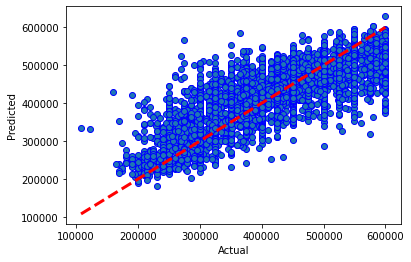

In [81]:
fig, ax = plt.subplots()
ax.scatter(y_test, best_estimator_pipe.predict(X_test), edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [82]:
def custom_model_and_predictions(model, graph_params, X_train, y_train, X_test):
    graph_model = model
    graph_model.set_params(**graph_params)
    graph_model.fit(X_train, y_train)
    y_pred_graph = model.predict(X_test)

    return model, y_pred_graph


best_model_count = 10 if not quick_mode else 2
best_model_count = 3 if not quick_mode else 1
best_models = {}
best_model_predictions = {}
best_model_scores = {}

showable_increment = total_fits // (4 if not quick_mode else 2)
for i in range(0, total_fits, showable_increment):
    if debug_mode or True: print(f'{i} ==> {i}')

    if i == 0:
        fitted_graph_model = crossval_runner.best_estimator_
        y_pred_graph = y_pred
    else:
        graph_pipe_params = cv_results_df_sorted['params'][i]
        print(graph_pipe_params)
        # would always return the best! graph_pipe_params = cv_results_df_sorted.loc[cv_results_df_sorted['rank_test_score'] == 1, 'params'].values[0]

        graph_params = {}
        for key, value in graph_pipe_params.items():
            graph_params[key.replace('model__', '')] = value

        fitted_graph_model, y_pred_graph = custom_model_and_predictions(starter_pipe, graph_pipe_params, X_train,
                                                                        y_train, X_test)

    best_models[i] = fitted_graph_model[-1].get_params()
    best_model_predictions[i] = y_pred_graph
    best_model_scores[i] = fitted_graph_model.score(X_test, y_test)

if debug_mode or True: print(f'{-1} ==> {-1}')
graph_pipe_params = cv_results_df_sorted['params'][total_fits - 1]
print(graph_pipe_params)
graph_params = {}
for key, value in graph_pipe_params.items():
    graph_params[key.replace('model__', '')] = value
fitted_graph_model, y_pred_graph = custom_model_and_predictions(starter_pipe, graph_pipe_params, X_train,
                                                                y_train, X_test)
best_models[-1] = fitted_graph_model[-1].get_params()
best_model_predictions[-1] = y_pred_graph
best_model_scores[-1] = fitted_graph_model.score(X_test, y_test)


0 ==> 0
2 ==> 2
{'model__learning_rate': 0.1, 'model__eval_metric': 'R2', 'model__depth': 5}


CatBoostError: You can't change params of fitted model.

In [ ]:
cv_results_df_sorted

In [ ]:
if debug_mode:
    cv_results_df_sorted['params']

In [ ]:
cv_results_df_sorted['params'][0]

In [ ]:
total_fits

In [ ]:
best_models

In [ ]:
for i in best_model_scores.keys():
    if i >= 0:
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
        plt.scatter(y_test, best_model_predictions[i])
        # plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
        if len(best_models[i].keys()) < 30:
            plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
        else:
            plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for entry " + str(i))
        plt.show()

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
plt.scatter(y_test, best_model_predictions[-1])
# plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
if len(best_models[i].keys()) < 30:
    plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for " + str(best_models[-1]))
else:
    plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for (worst) entry " + str(i))

plt.show()

In [ ]:
if True:
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    #.flatten()
    coordinates = axes[0]
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[0], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[0],
                    s=100).set(title=f'"BEST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[1], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[1],
                    s=100).set(title=f'"WORST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[2], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[2],
                    s=120, color='orange')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[2],
                    s=30, alpha=0.6, color='black').set(
        title='best (black) vs worst (orange)')
    #title='best (orange) vs worst (black)')

    fig.tight_layout()
    plt.show()

In [ ]:
cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"]
cv_best_model_fit_time

In [ ]:
cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"]

DD2 = "(".join(DATA_DETAIL) + ")" if len(DATA_DETAIL) >= 1 else ""
key = f'{ALGORITHM} - {ALGORITHM_DETAIL}{DD2} (v{VERSION})'.lower()

results = {
    '_score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    '_train time': cv_best_model_fit_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    '_params': crossval_runner.best_params_,
    'run_env': run_env
}

if run_env not in ['colab']:
    results_json = get_results()
    this_model_is_best = update_results(results_json, results, key)

print(key)

In [ ]:
crossval_runner.best_estimator_

In [ ]:
if this_model_is_best:
    with open(f'../../../models/optimised_model_{ALGORITHM}_v{VERSION}{DD2}.pkl', 'wb') as f:
        pickle.dump(crossval_runner.best_estimator_, f)
        print('pickled new version of model')
else:
    print("not updated saved model, the previous run was better")
    print(results_json[key]['best score'], 'better than', results_json[key]['_score'])

In [ ]:
if 'tree' in ALGORITHM.lower() or 'forest' in ALGORITHM.lower() or 'boost' in ALGORITHM.lower():
    feature_importances = crossval_runner.best_estimator_[-1].feature_importances_
    #std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)

    indices = np.argsort(feature_importances)[::-1]

    print('Feature Ranking:')

    for f in range(X_train.shape[1]):
        print('%d. features %d (%f)' % (f + 1, indices[f], feature_importances[indices[f]]),
              df_features.columns[indices[f] + 1])
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')

In [ ]:
if 'tree' in ALGORITHM.lower() or 'forest' in ALGORITHM.lower() or 'boost' in ALGORITHM.lower():
    feature_importances = crossval_runner.best_estimator_[-1].feature_importances_
    indices = np.argsort(feature_importances)

    fig, ax = plt.subplots()
    ax.barh(range(len(feature_importances)), feature_importances[indices])
    ax.set_yticks(range(len(feature_importances)))
    _ = ax.set_yticklabels(df_features.columns[[c + 1 for c in indices]])
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')

952:	learn: 0.8710017	total: 3.4s	remaining: 168ms
953:	learn: 0.8710616	total: 3.4s	remaining: 164ms
954:	learn: 0.8712488	total: 3.4s	remaining: 160ms
955:	learn: 0.8713463	total: 3.4s	remaining: 157ms
956:	learn: 0.8714676	total: 3.41s	remaining: 153ms
957:	learn: 0.8715611	total: 3.41s	remaining: 150ms
958:	learn: 0.8716821	total: 3.41s	remaining: 146ms
959:	learn: 0.8717721	total: 3.42s	remaining: 142ms
960:	learn: 0.8718881	total: 3.42s	remaining: 139ms
961:	learn: 0.8719587	total: 3.42s	remaining: 135ms
962:	learn: 0.8720668	total: 3.42s	remaining: 132ms
963:	learn: 0.8721899	total: 3.42s	remaining: 128ms
964:	learn: 0.8722691	total: 3.43s	remaining: 124ms
965:	learn: 0.8724019	total: 3.43s	remaining: 121ms
966:	learn: 0.8724778	total: 3.45s	remaining: 118ms
967:	learn: 0.8725943	total: 3.46s	remaining: 114ms
968:	learn: 0.8726763	total: 3.46s	remaining: 111ms
969:	learn: 0.8727641	total: 3.46s	remaining: 107ms
970:	learn: 0.8728207	total: 3.46s	remaining: 103ms
971:	learn: 0.87